In [41]:
# import necessary libs
import json
import random
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

rand_seed = 555

In [66]:
# open the intents
with open("../Final_Intents.json") as intents_json_file:
    intents = json.load(intents_json_file)

In [67]:
# inspect the keys (should be tag, questions, responses)
intent_list_keys = []
for intent in intents:
    intent_list_keys += list(intent.keys())

set(intent_list_keys)

{'answers', 'questions', 'responses', 'tag'}

In [68]:
# convert the key 'answers to responses'
intent_list_keys = []

for intent in intents:
    if "answers" in intent:
        intent["responses"] = intent.pop("answers")
    intent_list_keys.extend(intent.keys())

print(set(intent_list_keys))
print(f"There are {len(intents)} intents in the intent list.")

{'questions', 'tag', 'responses'}
There are 75 intents in the intent list.


In [45]:
lemmatizer = WordNetLemmatizer()

def preprocess_intent_list(intents: list[list[str]], qna=False):
    """Preprocesses text data for training
    """
    words = []
    classes = []
    documents = []
    ignoreLetters = ['?', '!', '.', ',']

    for intent in intents:
        for question in intent['questions']:
            wordList = nltk.word_tokenize(question)
            words.extend(wordList)
            documents.append((wordList, intent['tag']))
            if intent['tag'] not in classes:
                classes.append(intent['tag'])
        if qna:
            # responses
            for response in intent['responses']:
                wordList = nltk.word_tokenize(response)
                words.extend(wordList)
                documents.append((wordList, intent['tag']))

    
    words = [lemmatizer.lemmatize(word) for word in words if
         word not in ignoreLetters]

    words = sorted(set(words))
    
    classes = sorted(set(classes))

    training = []
    # zeros
    outputEmpty = [0] * len(classes)

    for document in documents:
        bag = []
        wordPatterns = document[0]
        # lemmatize word patterns
        wordPatterns = [lemmatizer.lemmatize(word.lower()) for word in wordPatterns]
        # create bag of words
        for word in words:
            bag.append(1) if word in wordPatterns else bag.append(0)

        outputRow = list(outputEmpty)
        outputRow[classes.index(document[1])] += 1
        training.append(bag + outputRow)

    random.shuffle(training)
    training = np.array(training)

    return training, set(words), classes


In [46]:
training, words, classes = preprocess_intent_list(intents)

# Separate the features (X) and labels (Y)
trainX = training[:, :len(words)]
trainY = training[:, len(words):]

trainX.shape, trainY.shape

((524, 741), (524, 10))

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    """Function to visualize model performance
    """
    history = results.history
    plt.figure()
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# input_dim is the number of features in your input data
input_dim = len(words)

# Create a Sequential model
base_model = Sequential()

# Add a Dense layer with 128 units/neurons and 'relu' activation function
base_model.add(Dense(128, input_dim=input_dim, activation='relu'))

# Add another Dense layer with 64 neurons
base_model.add(Dense(64, activation='relu'))

# Add the output layer with appropriate units and activation function
base_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the summary of the model
base_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 128)               94976     
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 10)                650       
                                                                 
Total params: 103,882
Trainable params: 103,882
Non-trainable params: 0
_________________________________________________________________


In [49]:
# train the model
base_model_results = base_model.fit(trainX, trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
84/84 [==============================] - 1s 3ms/step - loss: 1.8816 - accuracy: 0.3938 - val_loss: 1.7149 - val_accuracy: 0.3429
Epoch 2/200
84/84 [==============================] - 0s 2ms/step - loss: 1.2760 - accuracy: 0.5489 - val_loss: 1.4321 - val_accuracy: 0.4952
Epoch 3/200
84/84 [==============================] - 0s 2ms/step - loss: 0.8083 - accuracy: 0.7995 - val_loss: 1.3090 - val_accuracy: 0.5714
Epoch 4/200
84/84 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.9093 - val_loss: 1.2465 - val_accuracy: 0.5810
Epoch 5/200
84/84 [==============================] - 0s 2ms/step - loss: 0.2438 - accuracy: 0.9690 - val_loss: 1.3695 - val_accuracy: 0.5524
Epoch 6/200
84/84 [==============================] - 0s 3ms/step - loss: 0.1401 - accuracy: 0.9809 - val_loss: 1.3288 - val_accuracy: 0.5524
Epoch 7/200
84/84 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.9928 - val_loss: 1.3636 - val_accuracy: 0.5524
Epoch 8/200
8

84/84 [==============================] - 0s 2ms/step - loss: 1.7442e-04 - accuracy: 1.0000 - val_loss: 2.4565 - val_accuracy: 0.5714
Epoch 59/200
84/84 [==============================] - 0s 3ms/step - loss: 1.5564e-04 - accuracy: 1.0000 - val_loss: 2.4756 - val_accuracy: 0.5714
Epoch 60/200
84/84 [==============================] - 0s 2ms/step - loss: 1.5077e-04 - accuracy: 1.0000 - val_loss: 2.4850 - val_accuracy: 0.5714
Epoch 61/200
84/84 [==============================] - 0s 3ms/step - loss: 1.4140e-04 - accuracy: 1.0000 - val_loss: 2.4967 - val_accuracy: 0.5714
Epoch 62/200
84/84 [==============================] - 0s 2ms/step - loss: 1.3185e-04 - accuracy: 1.0000 - val_loss: 2.5091 - val_accuracy: 0.5714
Epoch 63/200
84/84 [==============================] - 0s 2ms/step - loss: 1.2599e-04 - accuracy: 1.0000 - val_loss: 2.5254 - val_accuracy: 0.5714
Epoch 64/200
84/84 [==============================] - 0s 2ms/step - loss: 1.1681e-04 - accuracy: 1.0000 - val_loss: 2.5308 - val_accuracy

Epoch 170/200
84/84 [==============================] - 0s 2ms/step - loss: 6.0316e-07 - accuracy: 1.0000 - val_loss: 3.6545 - val_accuracy: 0.5810
Epoch 171/200
84/84 [==============================] - 0s 2ms/step - loss: 5.7926e-07 - accuracy: 1.0000 - val_loss: 3.6639 - val_accuracy: 0.5905
Epoch 172/200
84/84 [==============================] - 0s 2ms/step - loss: 5.4540e-07 - accuracy: 1.0000 - val_loss: 3.6728 - val_accuracy: 0.5905
Epoch 173/200
84/84 [==============================] - 0s 2ms/step - loss: 5.2862e-07 - accuracy: 1.0000 - val_loss: 3.6823 - val_accuracy: 0.5905
Epoch 174/200
84/84 [==============================] - 0s 2ms/step - loss: 5.0472e-07 - accuracy: 1.0000 - val_loss: 3.6924 - val_accuracy: 0.5810
Epoch 175/200
84/84 [==============================] - 0s 2ms/step - loss: 4.7684e-07 - accuracy: 1.0000 - val_loss: 3.7046 - val_accuracy: 0.5905
Epoch 176/200
84/84 [==============================] - 0s 2ms/step - loss: 4.6176e-07 - accuracy: 1.0000 - val_loss: 3

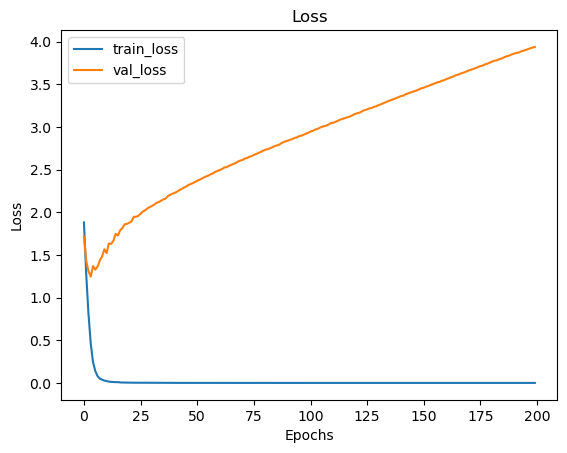

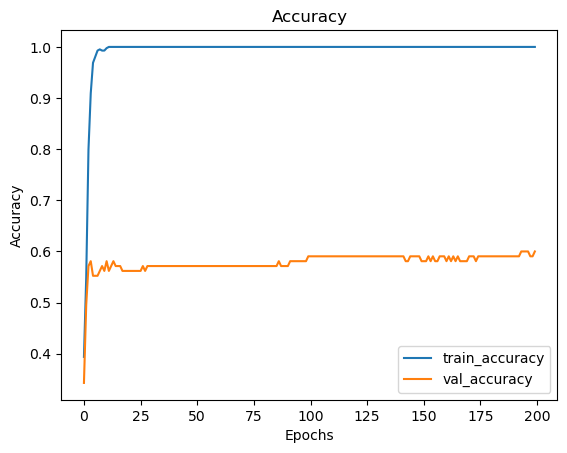

In [50]:
# visualize training results 
visualize_training_results(base_model_results)

### Summary of the `Base Model` Performance:

#### Key Observations:
1. **Overfitting Concerns:**
   - The training accuracy remains high **(around 98%)**, suggesting the model has learned well from the training data.
   - However, the validation accuracy has plateaued around **30-40%**, indicating a significant performance gap between training and validation sets.

2. **Validation Loss:**
   - The validation loss has increased substantially in the later epochs, reaching around 9.8. This further supports the overfitting concern.

#### Suggestions for Next Steps:
1. **Train on both questions and responses:** 
    - Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.
    
1. **Overfitting Mitigation - Regularization:**
   - Incorporating regularization techniques like dropout or L2 regularization to prevent overfitting. This may help the model generalize better to unseen data.
1. **Performance improvement mitigation:**
    - Overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:
    1. **Learning Rate Tuning:**
       - Experiment with different learning rates. 

    1. **Optimize the number of hidden layers**:
        - Tune the model by finding the appropriate number of hidden layers.

    1. **Testing out different vectorization methods.**
       - Test out the following vectorization strategies:
           - `TFIDF`
           - `embeddings`

1. If all fail, pick out a different deep learning model and repeat the above steps

### 1. Train on both questions and responses:
Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.

In [51]:
QnA_training, QnA_words, classes = preprocess_intent_list(intents, qna=True)

# Separate the features (X) and labels (Y) for each set
QnA_trainX = QnA_training[:, :len(QnA_words)]
QnA_trainY = QnA_training[:, len(QnA_words):]

In [52]:
QnA_trainX.shape, QnA_trainY.shape

((1040, 1880), (1040, 10))

In [53]:
# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model - same as the base model
model_2 = Sequential()
model_2.add(Dense(128, input_dim=input_dim, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model_2_results = model_2.fit(QnA_trainX, QnA_trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
167/167 [==============================] - 1s 4ms/step - loss: 1.6633 - accuracy: 0.4531 - val_loss: 1.2844 - val_accuracy: 0.6394
Epoch 2/200
167/167 [==============================] - 1s 3ms/step - loss: 0.7135 - accuracy: 0.8245 - val_loss: 0.7855 - val_accuracy: 0.7788
Epoch 3/200
167/167 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.9363 - val_loss: 0.6219 - val_accuracy: 0.7981
Epoch 4/200
167/167 [==============================] - 0s 2ms/step - loss: 0.1014 - accuracy: 0.9820 - val_loss: 0.5874 - val_accuracy: 0.8125
Epoch 5/200
167/167 [==============================] - 0s 3ms/step - loss: 0.0514 - accuracy: 0.9904 - val_loss: 0.6452 - val_accuracy: 0.7981
Epoch 6/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.9952 - val_loss: 0.5819 - val_accuracy: 0.8173
Epoch 7/200
167/167 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 0.9952 - val_loss: 0.6213 - val_accuracy: 0.8125

Epoch 58/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9976 - val_loss: 1.0703 - val_accuracy: 0.7933
Epoch 59/200
167/167 [==============================] - 0s 3ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 1.0811 - val_accuracy: 0.7981
Epoch 60/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9988 - val_loss: 1.0953 - val_accuracy: 0.7933
Epoch 61/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9976 - val_loss: 1.1050 - val_accuracy: 0.7933
Epoch 62/200
167/167 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 0.9976 - val_loss: 1.1160 - val_accuracy: 0.7981
Epoch 63/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9988 - val_loss: 1.1258 - val_accuracy: 0.7933
Epoch 64/200
167/167 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 1.1291 - val_accuracy:

Epoch 115/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9976 - val_loss: 1.5831 - val_accuracy: 0.7837
Epoch 116/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9988 - val_loss: 1.5914 - val_accuracy: 0.7837
Epoch 117/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9988 - val_loss: 1.5993 - val_accuracy: 0.7740
Epoch 118/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9976 - val_loss: 1.5970 - val_accuracy: 0.7837
Epoch 119/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9988 - val_loss: 1.6074 - val_accuracy: 0.7788
Epoch 120/200
167/167 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.9988 - val_loss: 1.6224 - val_accuracy: 0.7740
Epoch 121/200
167/167 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 0.9976 - val_loss: 1.6248 - val_ac

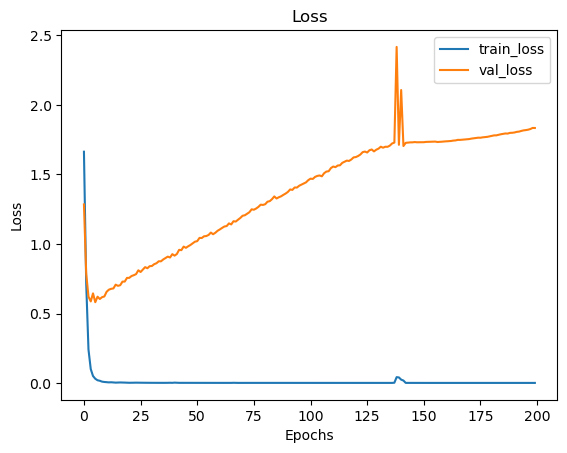

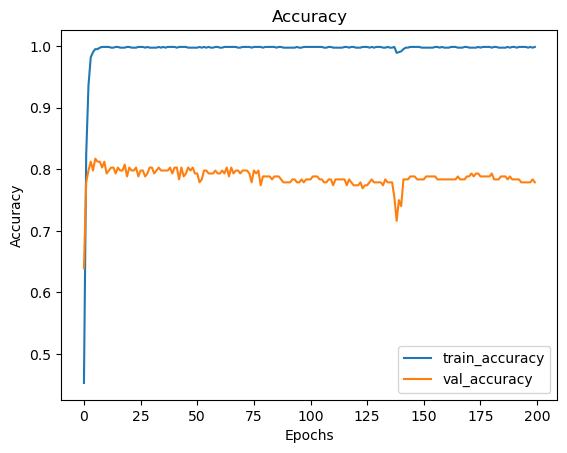

In [54]:
# visualize training results 
visualize_training_results(model_2_results)

### Summary of `model_2`:
 #### Key Observations:
1. **Training and Validation Metrics:**
   - The training accuracy has increased to approximately **99.42%**, while the validation accuracy has improved to around **58.78%**.
   - The training loss has decreased, reaching approximately 0.0084, and the validation loss is at 5.9267.

#### Progress and Adjustments:
1. **Performance Improvement:**
   - The model's performance has significantly improved compared to the previous iterations.

2. **Validation Accuracy:**
   - While the validation accuracy has increased, there may still be room for further improvement.

## 2. Regularization - Dropout regularization

In [55]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model
model_2_reg = Sequential()

# Add a Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.7))

# Add another Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.5))

# Output layer
model_2_reg.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization
model_2_reg_results = model_2_reg.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=5, verbose=1, validation_split=0.2)


Epoch 1/250
167/167 [==============================] - 1s 3ms/step - loss: 2.7953 - accuracy: 0.3594 - val_loss: 2.1059 - val_accuracy: 0.3942
Epoch 2/250
167/167 [==============================] - 1s 3ms/step - loss: 1.9587 - accuracy: 0.4315 - val_loss: 1.8350 - val_accuracy: 0.4375
Epoch 3/250
167/167 [==============================] - 0s 3ms/step - loss: 1.7226 - accuracy: 0.5240 - val_loss: 1.7001 - val_accuracy: 0.5288
Epoch 4/250
167/167 [==============================] - 0s 3ms/step - loss: 1.5766 - accuracy: 0.6166 - val_loss: 1.5697 - val_accuracy: 0.6346
Epoch 5/250
167/167 [==============================] - 0s 3ms/step - loss: 1.4859 - accuracy: 0.6659 - val_loss: 1.5327 - val_accuracy: 0.7067
Epoch 6/250
167/167 [==============================] - 1s 3ms/step - loss: 1.3842 - accuracy: 0.7103 - val_loss: 1.4878 - val_accuracy: 0.7212
Epoch 7/250
167/167 [==============================] - 1s 3ms/step - loss: 1.3697 - accuracy: 0.7416 - val_loss: 1.4626 - val_accuracy: 0.7500

Epoch 58/250
167/167 [==============================] - 1s 4ms/step - loss: 0.9230 - accuracy: 0.8786 - val_loss: 1.2434 - val_accuracy: 0.7837
Epoch 59/250
167/167 [==============================] - 1s 3ms/step - loss: 0.9331 - accuracy: 0.8858 - val_loss: 1.2417 - val_accuracy: 0.7692
Epoch 60/250
167/167 [==============================] - 0s 3ms/step - loss: 0.9035 - accuracy: 0.8858 - val_loss: 1.2136 - val_accuracy: 0.8077
Epoch 61/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8944 - accuracy: 0.9002 - val_loss: 1.2329 - val_accuracy: 0.7788
Epoch 62/250
167/167 [==============================] - 0s 3ms/step - loss: 0.9209 - accuracy: 0.8822 - val_loss: 1.2006 - val_accuracy: 0.7981
Epoch 63/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8820 - accuracy: 0.8966 - val_loss: 1.2492 - val_accuracy: 0.7740
Epoch 64/250
167/167 [==============================] - 1s 3ms/step - loss: 0.9217 - accuracy: 0.8870 - val_loss: 1.2235 - val_accuracy:

Epoch 115/250
167/167 [==============================] - 1s 4ms/step - loss: 0.8209 - accuracy: 0.8990 - val_loss: 1.2236 - val_accuracy: 0.7788
Epoch 116/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8280 - accuracy: 0.8954 - val_loss: 1.2164 - val_accuracy: 0.7644
Epoch 117/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8699 - accuracy: 0.8774 - val_loss: 1.1989 - val_accuracy: 0.7885
Epoch 118/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8599 - accuracy: 0.8750 - val_loss: 1.2010 - val_accuracy: 0.7933
Epoch 119/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8521 - accuracy: 0.8930 - val_loss: 1.2200 - val_accuracy: 0.7885
Epoch 120/250
167/167 [==============================] - 1s 3ms/step - loss: 0.7995 - accuracy: 0.9219 - val_loss: 1.1663 - val_accuracy: 0.8029
Epoch 121/250
167/167 [==============================] - 1s 3ms/step - loss: 0.8117 - accuracy: 0.9111 - val_loss: 1.1989 - val_ac

167/167 [==============================] - 0s 3ms/step - loss: 0.8487 - accuracy: 0.8954 - val_loss: 1.1401 - val_accuracy: 0.8173
Epoch 228/250
167/167 [==============================] - 1s 4ms/step - loss: 0.7953 - accuracy: 0.8942 - val_loss: 1.1737 - val_accuracy: 0.8029
Epoch 229/250
167/167 [==============================] - 1s 4ms/step - loss: 0.8166 - accuracy: 0.8978 - val_loss: 1.1946 - val_accuracy: 0.7788
Epoch 230/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8207 - accuracy: 0.8966 - val_loss: 1.1636 - val_accuracy: 0.7885
Epoch 231/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8141 - accuracy: 0.9026 - val_loss: 1.1747 - val_accuracy: 0.7788
Epoch 232/250
167/167 [==============================] - 0s 3ms/step - loss: 0.8216 - accuracy: 0.8954 - val_loss: 1.1713 - val_accuracy: 0.7933
Epoch 233/250
167/167 [==============================] - 1s 3ms/step - loss: 0.8083 - accuracy: 0.9026 - val_loss: 1.1691 - val_accuracy: 0.7933

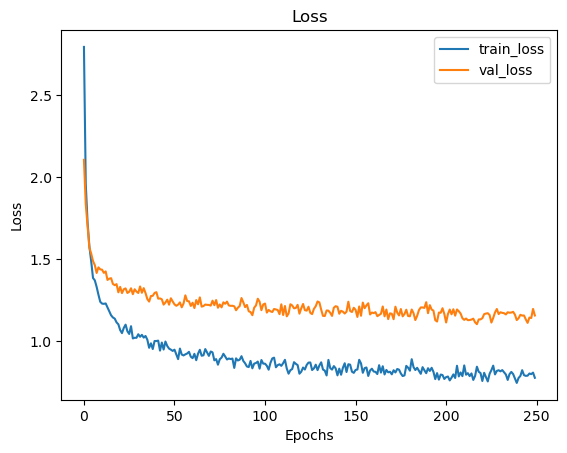

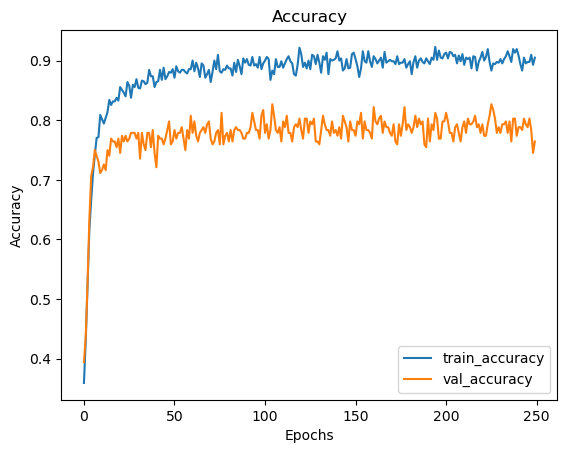

In [56]:
visualize_training_results(model_2_reg_results)

### Model Training Update:

#### Key Training Metrics:
1. **Accuracy:**
   - Training Accuracy: ~84%
   - Validation Accuracy: ~60%
  
2. **Loss:**
   - Training Loss: ~1.32
   - Validation Loss: ~3.55

#### Observations:
1. **Reduced overfitting:**
   - Even though the training accuracy remains relatively high, there is a noticeable reduction in overfitting.

2. **Loss Trends:**
   - The training loss is lower than previous epochs, indicating continued learning. However, the validation loss is relatively high.


### 3. Performance improvement mitigation:
Any form of overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:

#### 3.1 Learning Rate Tuning:
- Experiment with a different learning rate.

In [57]:
from keras.optimizers import Adam

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
84/84 [==============================] - 1s 5ms/step - loss: 2.6081 - accuracy: 0.3618 - val_loss: 1.8646 - val_accuracy: 0.3942
Epoch 2/250
84/84 [==============================] - 0s 3ms/step - loss: 1.7278 - accuracy: 0.4519 - val_loss: 1.6197 - val_accuracy: 0.5096
Epoch 3/250
84/84 [==============================] - 0s 3ms/step - loss: 1.4590 - accuracy: 0.5589 - val_loss: 1.4035 - val_accuracy: 0.6202
Epoch 4/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2626 - accuracy: 0.6839 - val_loss: 1.2544 - val_accuracy: 0.7500
Epoch 5/250
84/84 [==============================] - 0s 4ms/step - loss: 1.0528 - accuracy: 0.7849 - val_loss: 1.1449 - val_accuracy: 0.7308
Epoch 6/250
84/84 [==============================] - 0s 3ms/step - loss: 0.9598 - accuracy: 0.8053 - val_loss: 1.0902 - val_accuracy: 0.7692
Epoch 7/250
84/84 [==============================] - 0s 3ms/step - loss: 0.8524 - accuracy: 0.8438 - val_loss: 1.0707 - val_accuracy: 0.7692
Epoch 8/250
8

Epoch 59/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4134 - accuracy: 0.9675 - val_loss: 1.0081 - val_accuracy: 0.7885
Epoch 60/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.9639 - val_loss: 0.9917 - val_accuracy: 0.7933
Epoch 61/250
84/84 [==============================] - 0s 4ms/step - loss: 0.4000 - accuracy: 0.9627 - val_loss: 1.0378 - val_accuracy: 0.7837
Epoch 62/250
84/84 [==============================] - 0s 5ms/step - loss: 0.4249 - accuracy: 0.9651 - val_loss: 1.0605 - val_accuracy: 0.7885
Epoch 63/250
84/84 [==============================] - 0s 4ms/step - loss: 0.3929 - accuracy: 0.9567 - val_loss: 1.1028 - val_accuracy: 0.7596
Epoch 64/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3703 - accuracy: 0.9772 - val_loss: 0.9929 - val_accuracy: 0.7740
Epoch 65/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.9663 - val_loss: 0.9543 - val_accuracy: 0.8029
Epoch 

84/84 [==============================] - 0s 4ms/step - loss: 0.3405 - accuracy: 0.9796 - val_loss: 1.1039 - val_accuracy: 0.7885
Epoch 174/250
84/84 [==============================] - 0s 4ms/step - loss: 0.3529 - accuracy: 0.9675 - val_loss: 1.1072 - val_accuracy: 0.7788
Epoch 175/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3784 - accuracy: 0.9615 - val_loss: 1.2321 - val_accuracy: 0.7740
Epoch 176/250
84/84 [==============================] - 0s 3ms/step - loss: 0.4005 - accuracy: 0.9579 - val_loss: 1.1818 - val_accuracy: 0.7644
Epoch 177/250
84/84 [==============================] - 0s 4ms/step - loss: 0.3654 - accuracy: 0.9663 - val_loss: 1.1297 - val_accuracy: 0.7837
Epoch 178/250
84/84 [==============================] - 0s 4ms/step - loss: 0.3529 - accuracy: 0.9760 - val_loss: 1.1592 - val_accuracy: 0.7837
Epoch 179/250
84/84 [==============================] - 0s 3ms/step - loss: 0.3719 - accuracy: 0.9700 - val_loss: 1.1517 - val_accuracy: 0.8077
Epoch 180/250

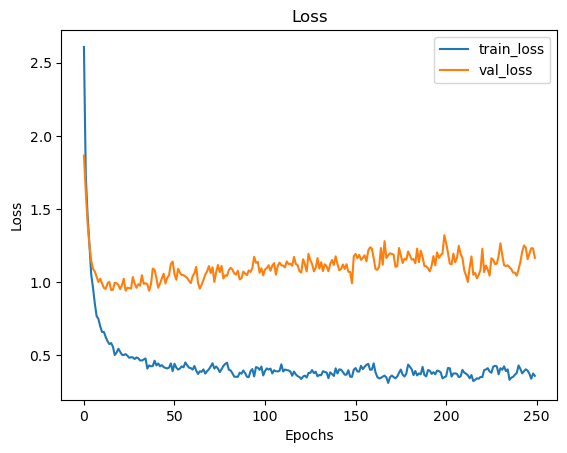

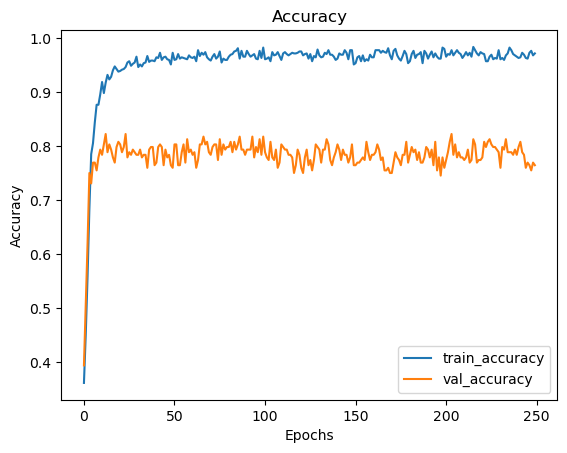

In [58]:
visualize_training_results(model_2_reg_results_opt)

### 3.2 Optimize the number of hidden layers:

Tune the model by finding the:
- appropriate number of hidden layers
- the number of neurons per layer.

In [59]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(50, activation='relu'))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
84/84 [==============================] - 1s 5ms/step - loss: 4.0871 - accuracy: 0.3726 - val_loss: 3.5529 - val_accuracy: 0.3942
Epoch 2/250
84/84 [==============================] - 0s 3ms/step - loss: 3.2051 - accuracy: 0.4135 - val_loss: 2.8660 - val_accuracy: 0.4279
Epoch 3/250
84/84 [==============================] - 0s 3ms/step - loss: 2.6410 - accuracy: 0.4856 - val_loss: 2.4240 - val_accuracy: 0.5337
Epoch 4/250
84/84 [==============================] - 0s 4ms/step - loss: 2.2307 - accuracy: 0.5288 - val_loss: 2.0653 - val_accuracy: 0.5865
Epoch 5/250
84/84 [==============================] - 0s 3ms/step - loss: 1.9471 - accuracy: 0.5853 - val_loss: 1.8747 - val_accuracy: 0.6202
Epoch 6/250
84/84 [==============================] - 0s 3ms/step - loss: 1.6768 - accuracy: 0.6418 - val_loss: 1.7436 - val_accuracy: 0.6250
Epoch 7/250
84/84 [==============================] - 0s 3ms/step - loss: 1.5105 - accuracy: 0.6659 - val_loss: 1.5883 - val_accuracy: 0.6587
Epoch 8/250
8

Epoch 59/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2793 - accuracy: 0.8462 - val_loss: 1.5643 - val_accuracy: 0.7163
Epoch 60/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2314 - accuracy: 0.8474 - val_loss: 1.6065 - val_accuracy: 0.7308
Epoch 61/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2091 - accuracy: 0.8474 - val_loss: 1.5238 - val_accuracy: 0.7452
Epoch 62/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2870 - accuracy: 0.8209 - val_loss: 1.5011 - val_accuracy: 0.7404
Epoch 63/250
84/84 [==============================] - 0s 3ms/step - loss: 1.1707 - accuracy: 0.8630 - val_loss: 1.5171 - val_accuracy: 0.7500
Epoch 64/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2497 - accuracy: 0.8281 - val_loss: 1.5084 - val_accuracy: 0.7356
Epoch 65/250
84/84 [==============================] - 0s 4ms/step - loss: 1.2355 - accuracy: 0.8329 - val_loss: 1.5874 - val_accuracy: 0.7115
Epoch 

84/84 [==============================] - 0s 3ms/step - loss: 1.1152 - accuracy: 0.8462 - val_loss: 1.4633 - val_accuracy: 0.7212
Epoch 174/250
84/84 [==============================] - 0s 3ms/step - loss: 1.1962 - accuracy: 0.8341 - val_loss: 1.5197 - val_accuracy: 0.7260
Epoch 175/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2074 - accuracy: 0.8245 - val_loss: 1.4913 - val_accuracy: 0.7019
Epoch 176/250
84/84 [==============================] - 0s 4ms/step - loss: 1.2581 - accuracy: 0.8293 - val_loss: 1.5409 - val_accuracy: 0.7260
Epoch 177/250
84/84 [==============================] - 0s 3ms/step - loss: 1.1392 - accuracy: 0.8498 - val_loss: 1.5107 - val_accuracy: 0.7019
Epoch 178/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2099 - accuracy: 0.8269 - val_loss: 1.4501 - val_accuracy: 0.7500
Epoch 179/250
84/84 [==============================] - 0s 3ms/step - loss: 1.1811 - accuracy: 0.8425 - val_loss: 1.4072 - val_accuracy: 0.7404
Epoch 180/250

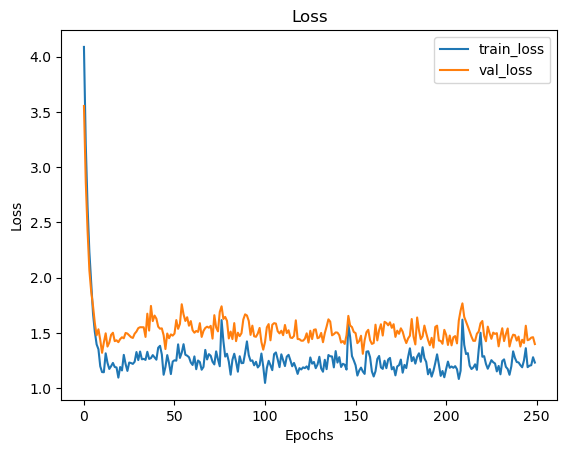

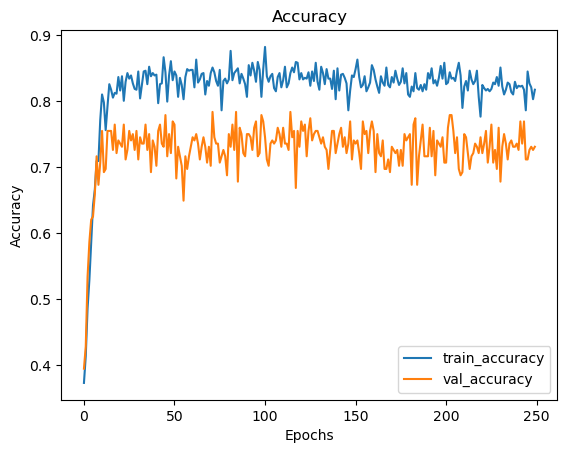

In [60]:
visualize_training_results(model_2_reg_results_opt)

### 3.3 Testing out different vectorization methods.
Test out the following vectorization strategies:
   - `TFIDF`
   - `embeddings`


### 3.3.1 Term Frequency * Inverse Document Frequency (TFIDF) vectorization

In [61]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
ignoreLetters = ['?', '!', '.', ',']
    
def preprocess_qnas(df):
    # Lowercase all text in the "QnAs" column
    df['QnAs'] = df['QnAs'].str.lower()
    
    # Tokenize the text in the "QnAs" column
    df['QnAs'] = df['QnAs'].apply(word_tokenize)
    
    # Remove stopwords from the tokenized text in the "QnAs" column
    stop_words = set(stopwords.words('english'))
    
    df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
#     df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in ignoreLetters])

    df['QnAs'] = df['QnAs'].apply(lambda x: " ".join(x))
    
    return  df



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
import json
import pandas as pd
from nltk.stem import WordNetLemmatizer
import numpy as np

lemmatizer = WordNetLemmatizer()

# open the intents
with open("../Final_Intents.json") as intents_json_file:
    intents = json.load(intents_json_file)

QnAs = []
tags = []

for intent in intents:
    for question in intent["questions"]:
        QnAs.append(question)
        tags.append(intent['tag'])
    for response in intent["responses"]:
        QnAs.append(response)
        tags.append(intent['tag'])
# Preprocess the text by lemmatizing and lowercasing

qna_df = pd.DataFrame({"QnAs": QnAs, "tags": tags})

qna_df["QnAs"] = qna_df["QnAs"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) for word in x.split()]))

qna_df = qna_df.reindex(np.random.permutation(qna_df.index))
qna_df = preprocess_qnas(qna_df)
qna_df.head()

,QnAs,tags
785,change course enrollment deadline ?,Enrollment
255,"prior work experience necessary , course suita...",Data Science
1016,collaboration enhances overall learning experi...,Miscellaneous
408,talent acquisition specialist engage practical...,Data Science
418,"absolutely , ensure advanced topic line latest...",Data Science


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd

# TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=0, max_features=None, strip_accents='unicode', analyzer='word', stop_words='english')
# vectorizer = CountVectorizer()

X_vectorized = vectorizer.fit_transform(qna_df["QnAs"])

trainX_idf = X_vectorized.todense()

trainY_idf = pd.get_dummies(qna_df["tags"])

In [ ]:
trainX_idf.shape, trainY_idf.shape

In [ ]:
# visualize_training_results(model.history)

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential

sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

input_dim = trainX_idf.shape[1]

classes = set(tags)

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu'))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='tanh'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(150, activation='tanh'))
# model_2_reg_opt.add(Dense(150, activation='relu'))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# summary
model_2_reg_results_opt = model_2_reg_opt.fit(trainX_idf, trainY_idf, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

In [ ]:
visualize_training_results(model_2_reg_results_opt)

In [ ]:
training, words, classes = preprocess_intent_list(intents)

# Separate the features (X) and labels (Y)
trainX = training[:, :len(words)]
trainY = training[:, len(words):]

trainX.shape, trainY.shape, 

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(trainX_idf.shape[1],), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(trainY_idf.shape[1], activation='softmax'))

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

results = model.fit(trainX_idf, trainY_idf, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

visualize_training_results(results)

In [ ]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence
    
# test
clean_text("Remove punctuations and return lemmatized tokens")

In [ ]:
# example
text = "What is the fundamental starting point for understanding Cloud Computing ?"

prep_text = clean_text(text)
vectorized_txt = vectorizer.transform(prep_text)

pred = model_2_reg_opt.predict(vectorized_txt)


In [ ]:
# [intent for intent in intents if intent["tag"] == "Contact"]

In [ ]:

ERR_THRESH = 0.55
unique_labels = qna_df["tags"].unique()

results = [[np.argmax(r), r[np.argmax(r)]] for i, r in enumerate(pred) if any(r > ERR_THRESH)]

print(f"Predicted classes: {results}")
for res in results:
    print(f"{res[0]}: {unique_labels[res[0]]}, {round(res[1]*100)}%")

In [ ]:
toks_ls = [string.split() for string in qna_df["QnAs"].values]
QnA_words = []
for toks in toks_ls:
    QnA_words += toks

glove = {}
with open('glove.6B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in QnA_words:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

### 3.3.2 Word Embeddings

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [ ]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr),
#          ("XGBClassifier", xgboost)
         ]

In [ ]:
from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# apply on df
qna_df['label'] = encoder.fit_transform(qna_df['tags'])

target = qna_df['label']
data = qna_df['QnAs'].map(word_tokenize).values

In [ ]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

In [ ]:
scores

In [ ]:
lr.__dict__

In [76]:
new_intent_list = {"Data Science":[
"Data_Science_Courses",
"Data_Science_Career",
"Data_Science_Course_Overview",
"Data_Science_Course_Duration_and_Fees",
"Data_Science_Admission_Eligibility_Criteria",
"Data_Science_Career_Opportunities",
"Data_Science_Curriculum_Outline",
"Data_Science_Pre-Work_Requirements",
"Data_Science_Skill_Development",
"Data_Science_Project_and_Hands-on_Experience",
"Data_Science_Industry_Relevance",
"Data_Science_Software_Engineering_Fundamentals",
"Data_Science_Statistics_and_Analysis",
"Data_Science_Networking_and_Collaboration_Opportunities",
"Data_Science_Course_Schedule_and_Structure",
"Data_Science_Online_and_Offline_Learning_Modes",
"Data_Science_Student_Support_Services",
"Data_Science_Certification_and_Accreditation",
"Data_Science_Application_Process",
"Data_Science_Cybersecurity_Introduction",
"Data_Science_Applications_in_Business",
"Ethical_Considerations_in_Data_Science",
"Data_Science_Collaborative_Projects_and_Teamwork",
"Data_Science_Career_Transition_Support",
"Data_Ethics_and_Privacy",
"hr_data_analytics",
"Advanced_Data_Science_Topics"],

"DevOps":[
"DevOps_Course_Information",
"DevOps_Career_Opportunities",
"DevOps_Admissions_and_Fees",
],

"Cybersecurity":[
"Cybersecurity_Career_Opportunities",
"Cybersecurity_Course_Information",
"Cybersecurity_Certifications"],

"Software Engineering":
[
"Full_Stack_Software_Engineering",
"Software_Engineering_Mobile_Track",
"Part-time_Software Engineering",
"Part-time_Course_Content",
"Software_Engineering_Course_Content",
"ai_integration"],

"UI/UX":[
"Product_Design_UI/UX_Course_Information",
"Product_Design_UI/UX_Career_Opportunities"],

"Cloud Computing":[
"aws_cloud_course",
"aws_cloud_practitioner",
"cloud_developer_role",
],
"Enrollment":[
"Enrollment_Information",
"Enrollment_Information",
"detailed_schedule",
"enrollment_deadline"],
"Mobile Development":[
"Mobile Development",
"Mobile_Development_Courses",
"Mobile_Development_Career"],
"Contacts":
["Contact"],
"Miscellaneous":[
"Moringa_School_Courses",
"Moringa_School_News",
"Moringa_School_Testimonials",
"Event",
"Partnership",
"Financial Aid",
"Mpesa_Mini_Apps_API_Course_Information"]
}


In [98]:
new_intents = []



for key, val in new_intent_list.items():
    int_elems = {"tag":None, "questions":[], "responses":[]}
    int_elems["tag"] = key
    for intent_tag in val:
#             print(int_elems["questions"])
            int_elems["questions"] += [intent["questions"] for intent in intents if intent["tag"] == intent_tag ][0]
            int_elems["responses"] += [intent["responses"] for intent in intents if intent["tag"] == intent_tag ][0]
    new_intents.append(int_elems)

In [99]:
[intent["tag"] for intent in new_intents]

['Data Science',
 'DevOps',
 'Cybersecurity',
 'Software Engineering',
 'UI/UX',
 'Cloud Computing',
 'Enrollment',
 'Mobile Development',
 'Contacts',
 'Miscellaneous']

In [100]:
import json
with open("../Final_Intents.json", "w") as f:
    json.dump(new_intents, f)